In [1]:
import os
import time
import cv2
import random
import torch, torchvision, torchinfo
from torchvision.models import ResNet
from torchvision.models.resnet import Bottleneck, BasicBlock
from torchvision import transforms
from torch import nn
from typing import Type, Any, Callable, Union, List, Optional
# from torch.hub import load_state_dict_from_url
import numpy as np
from torch.utils.data import Dataset, DataLoader
from log_dice_loss import *

# torch.backends.cuda.matmul.allow_tf32 = False
# torch.backends.cudnn.allow_tf32 = True
# os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'
torch.use_deterministic_algorithms(True)
torch.__version__

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/haobo/.local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/haobo/.local/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail19maybe_wrap_dim_slowEllb
  warn(f"Failed to load image Python extension: {e}")


'1.11.0+cu113'

In [2]:
# OK it seems backprop of bilinear upsampling is not deterministic

In [3]:
def setup_seed(seed):
     os.environ['PYTHONHASHSEED'] =str(seed)
     torch.manual_seed(seed)
     # torch.cuda.manual_seed(seed)
     # torch.cuda.manual_seed_all(seed)
     # torch.backends.cudnn.deterministic = True
     # torch.backends.cudnn.benchmark = False 
     np.random.seed(seed)
     random.seed(seed)
     # torch.backends.cudnn.deterministic = True

seed = 420
setup_seed(seed)
import segmentation_models_pytorch as smp
import imgaug
imgaug.random.seed(seed)
import albumentations as albu
import matplotlib.pyplot as plt


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# defines a factory function to produce the encoder
def seg_resnet34(attention="scse"):

    resnet34 = torchvision.models.resnet34(pretrained=True)
    cnn = SegResNet(BasicBlock, [3, 4, 6, 3], attention=attention)
    #读取参数
    pretrained_dict = resnet34.state_dict()
    model_dict = cnn.state_dict()
    # 将pretrained_dict里不属于model_dict的键剔除掉
    pretrained_dict =  {k: v for k, v in pretrained_dict.items() if k in model_dict}
    # 更新现有的model_dict
    model_dict.update(pretrained_dict)
    # 加载我们真正需要的state_dict
    cnn.load_state_dict(model_dict)
    return cnn


# the encoder class
class SegResNet(ResNet):

    def __init__(self, block, layers, attention='scse'):
        super().__init__(block, layers)
        self.out_channels = (64, 64, 128, 256, 512)
        self.attention1 = Attention(attention, in_channels=64)
        self.attention2 = Attention(attention, in_channels=64)
        self.attention3 = Attention(attention, in_channels=128)
        self.attention4 = Attention(attention, in_channels=256)
        self.attention5 = Attention(attention, in_channels=512)
        del self.fc
        del self.avgpool

    def get_stages(self):
        return [
            nn.Identity(),
            nn.Sequential(self.conv1, self.bn1, self.relu),
            self.attention1,
            nn.Sequential(self.maxpool, self.layer1),
            self.attention2, 
            self.layer2,
            self.attention3, 
            self.layer3,
            self.attention4,
            self.layer4,
            self.attention5,
        ]

    # def load_state_dict(self, state_dict, **kwargs):
    #     state_dict.pop("fc.bias", None)
    #     state_dict.pop("fc.weight", None)
    #     super().load_state_dict(state_dict, **kwargs)
        
    def forward(self, x):
        features = []
        stages = self.get_stages()
        for layer in stages:
            x = layer(x)
            if isinstance(layer, Attention):
                
                features.append(x)
        return features



class SCSEModule(nn.Module):

    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.cSE = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),                                # [N, C, H, W] -> [N, C, 1, 1]
            nn.Conv2d(in_channels, in_channels//reduction, 1),      # [N, C, 1, 1] -> [N, C/2, 1, 1]
            nn.ReLU(inplace=True),                             
            nn.Conv2d(in_channels//reduction, in_channels, 1),      # [N, C/2, 1, 1] -> [N, C, 1, 1]
            nn.Sigmoid(),
        )
        self.sSE = nn.Sequential(nn.Conv2d(in_channels, 1, 1),      # [N, C, H, W] -> [N, 1, H, W]
                                 nn.Sigmoid())

    def forward(self, x):
        return x * self.cSE(x) + x * self.sSE(x)



class Attention(nn.Module):

    def __init__(self, name, **params):
        super().__init__()

        if name is None:
            self.attention = nn.Identity(**params)
        elif name == 'scse':
            self.attention = SCSEModule(**params)
        else:
            raise ValueError("Attention {} is not implemented".format(name))

    def forward(self, x):
        return self.attention(x)



### following classes supports the decoder
class Conv2dBnRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=(3, 3), Dropout: bool = True):
        super().__init__()
        self.dropout = nn.Dropout2d(0.2) if Dropout else nn.Identity()
        # self.encoder = seg_resnet34()
        # self.upsample = nn.Upsample(scale_factor=2, mode="bilinear")
        self.conv = nn.Conv2d(in_channels=in_channels, 
                              out_channels=out_channels, 
                              kernel_size=kernel_size, 
                              padding="same", 
                              bias=False)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, input):
        x = self.dropout(input)
        x = self.conv(x)
        x = self.bn(x)
        out = self.relu(x)
        return(out)
        # features = self.encoder(input)
        # features  = features[::-1]



class DecoderBlock(nn.Module):
    def __init__(self,
                 in_channels,
                 skip_channels,
                 out_channels,
                 kernel_size=(3, 3), 
                 attention=None,
                 Dropout = 0.2):

        super().__init__()
        # print(in_channels+skip_channels)
        # self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)
        self.upsample = nn.Upsample(scale_factor=2, mode="nearest",)
        self.conv1 = Conv2dBnRelu(in_channels + skip_channels,
                                    out_channels,
                                    kernel_size=kernel_size,
                                    Dropout=Dropout
                                    )

        self.attention1 = Attention(attention, in_channels = in_channels + skip_channels)

        self.conv2 = Conv2dBnRelu(out_channels, 
                                    out_channels, 
                                    kernel_size=kernel_size, 
                                    Dropout=Dropout
                                    )

        self.attention2 = Attention(attention, in_channels=out_channels)                                    
    
    def forward(self, x:torch.Tensor, skip=None):
        x = self.upsample(x)
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
            # print(skip.shape)
            x = self.attention1(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.attention2(x)
        return x

class UnetDecoder(nn.Module):
    def __init__(
            self,
            encoder_channels,
            decoder_channels,
            n_blocks=5,
            attention_type="scse",
            Dropout = 0.2
    ):
        super().__init__()

        if n_blocks != len(decoder_channels):
            raise ValueError(
                "Model depth is {}, but you provide `decoder_channels` for {} blocks.".format(
                    n_blocks, len(decoder_channels)
                )
            )

        # encoder_channels = encoder_channels[1:]  # remove first skip with same spatial resolution
        encoder_channels = encoder_channels[::-1]  # reverse channels to start from head of encoder
        # print(encoder_channels)
        # computing blocks input and output channels
        head_channels = encoder_channels[0]
        in_channels = [head_channels] + list(decoder_channels[:-1])
        skip_channels = list(encoder_channels[1:]) + [0]
        out_channels = decoder_channels
       # print(in_channels, skip_channels, out_channels)
        
        self.center = nn.Identity()

        # combine decoder keyword arguments
        kwargs = dict(Dropout=0.2, attention=attention_type)
        blocks = [
            DecoderBlock(in_ch, skip_ch, out_ch, Dropout=0.2, attention=attention_type)
            for in_ch, skip_ch, out_ch in zip(in_channels, skip_channels, out_channels)
        ]
        self.blocks = nn.ModuleList(blocks)

    def forward(self, features:List[torch.Tensor]):

        # features = features[1:]    # remove first skip with same spatial resolution
        features = features[::-1]  # reverse channels to start from head of encoder
        # print(features)
        head = features[0]
        skips = features[1:]

        # print(len(skips))
        x = self.center(head)
        for i, decoder_block in enumerate(self.blocks):
            # print("decoder_block")
            skip = skips[i] if i < len(skips) else None
            # print(x.shape, skip.shape)
            # print(skip.shape)
            x = decoder_block(x, skip)

        return x

class Unet(nn.Module):
    def __init__(
        self,
        decoder_channels: List[int] = [256, 128, 64, 32, 16],
        attention="scse", 
        activation=nn.Softmax(dim=1),
        classes=3,
        Dropout = 0.2
    ):
        super().__init__()
        self.encoder = seg_resnet34(attention=attention)
        self.decoder = UnetDecoder(
            encoder_channels=self.encoder.out_channels, 
            decoder_channels=decoder_channels, 
            attention_type=attention,
            Dropout = Dropout
        )
        self.dropout = nn.Dropout2d(Dropout) if Dropout else nn.Identity()
        self.outconv = nn.Conv2d(decoder_channels[-1], classes, 3, padding="same")
        self.activation = activation

    def forward(self, x):
        # print(self.encoder.out_channels)
        features = self.encoder(x)
        # print(len(features))
        decoder_out = self.decoder(features)
        seg_out = self.dropout(decoder_out)
        seg_out = self.outconv(decoder_out)

        if self.activation is not None:
            out = self.activation(seg_out)
        return out


In [19]:
def CCE_loss(y_pred, y_true):
        y_pred_log = torch.log(y_pred)
        nll_loss = nn.NLLLoss(reduction="mean")
        loss = nll_loss(y_pred_log, y_true.argmax(dim=1))
        return loss

def CCE_loss_2():
    epsilon = 1.e-7
    def _loss(y_pred, y_true):
        # y_true = 

        y_pred = y_pred / torch.sum(y_pred, dim=1, keepdim=True)
        y_pred = torch.clamp(y_pred, epsilon, 1-epsilon)


        # y_t = tf.multiply(y_true, y_pred)
        ce = y_true * torch.log(y_pred)
        ce_out = - torch.mean(ce)
        return ce_out

    return _loss


from segmentation_models_pytorch import utils
class total_loss(nn.Module):
    def __init__(self):
        super().__init__()
        self.dice_loss = smp.utils.losses.DiceLoss()
        self.CCE_loss = CCE_loss_2()
        # self.softmax = nn.Softmax(dim=1)
    

    def forward(self, y_pred, y_true):
        dice_loss = self.dice_loss(y_pred, y_true)
        CCE_loss = self.CCE_loss(y_pred, y_true)
        return dice_loss + CCE_loss


@torch.no_grad()
def dice_metric(y_pred, y_true):
    _dice1 = utils.metrics.Fscore(threshold=0.5, ignore_channels=[1,2], mode="img_mean")
    _dice2 = utils.metrics.Fscore(threshold=0.5, ignore_channels=[0,2], mode="img_mean")
    dice_1 = _dice1(y_pred, y_true)
    dice_2 = _dice2(y_pred, y_true)
    return (dice_1.item(), dice_2.item())


In [7]:
pre_transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])


In [8]:
class SegDataset(Dataset):
    def __init__(
        self, 
        images_dir, 
        masks_dir, 
        classes=None, 
        augmentation=None, 
        preprocessing=None,
    ):
        self.CLASSES = ["myocardium", "chamber"]
        images_dirs = os.listdir(images_dir)
        # np.random.shuffle(images_dirs)
        self.ids = images_dirs
        # self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]

        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) + 1 for cls in classes]

        self.augmentation = augmentation
        self.preprocessing = preprocessing
        
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values ]
        mask = np.stack(masks, axis=-1).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        # apply preprocessing
        if self.preprocessing:
            image = self.preprocessing(image)
            mask = torch.Tensor(mask).permute(2, 0, 1)
            
        return image, mask, self.images_fps[i]
        
    def __len__(self):
        return len(self.ids)

In [9]:
def train_step(x, y_true):
    optim.zero_grad()
    # model.train()
    y_pred = model(x)
    loss = criterion(y_pred, y_true)
    loss.backward()
    optim.step()
    metric = dice_metric(y_pred, y_true)
    # metric=smp.utils.metrics.Fscore()(y_pred, y_true)
    return loss.item(), *metric

@torch.no_grad()
def val_step(x, y_true):
    # model.eval()
    y_pred = model(x)
    loss = criterion(y_pred, y_true)
    metric = dice_metric(y_pred, y_true)
    return loss.item(), *metric
        
def get_training_augmentation():
    train_transform = [

        # albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.05, rotate_limit=10, shift_limit=0.1, p=1, border_mode=0),

        # albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        # albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.GaussNoise(p=0.2),
        albu.Perspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightnessContrast(contrast_limit=0 ,p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                #albu.RandomContrast(p=1),
                albu.RandomBrightnessContrast(brightness_limit=0, p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(320, 320)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')





In [10]:
x_train_dir = "all_set_f_cropped/"
y_train_dir = "all_set_m_cropped/"
train_valid_set = SegDataset(x_train_dir, y_train_dir, classes=["myocardium", "chamber"], augmentation=get_training_augmentation(), preprocessing=pre_transform)

FileNotFoundError: [Errno 2] No such file or directory: 'all_set_f_cropped/'

In [11]:
import copy
def seed_workers(worker_id):
    # print(torch.initial_seed())
    worker_seed = torch.initial_seed() % 2**32
    imgaug.random.seed(worker_seed)
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    # print(worker_seed)

# seed_workers(1)
weight_decay = 0
EPOCHS = 80
lr = 1e-4
BATCH_SIZE = 16
Dropout = 0.2
model = Unet(attention=None, Dropout=Dropout).to(device)

# model.load_state_dict(torch.load("model_iter80_noatt_acc8694+9266_seed100_nearest_n128.pth"))
optim = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=weight_decay)
# criterion = total_loss()
criterion = log_dice_loss()

g = torch.Generator()
g.manual_seed(seed)

# print(train_valid_set)
train_len = len(train_valid_set)//5*4
train_set, val_set = torch.utils.data.random_split(train_valid_set, [train_len, len(train_valid_set) - train_len])
train_set.dataset = copy.deepcopy(train_valid_set)

val_set.dataset.augmentation=None
# train_set.dataset.augmentation=None
train_set.dataset.augmentation=get_training_augmentation()
train_dataloader = DataLoader(train_set, BATCH_SIZE, shuffle=True, num_workers=4, worker_init_fn=seed_workers, generator=g, pin_memory=True)
val_dataloader = DataLoader(val_set, BATCH_SIZE, shuffle=False, num_workers=4, worker_init_fn=seed_workers, generator=g, pin_memory=True)
# plt.imshow(val_set[0][1])
# print(train_set[0][2])
# print(train_set.dataset.augmentation)
# print(model)

/home/haobo/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/haobo/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


NameError: name 'train_valid_set' is not defined

In [12]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(comment=f"noAtt_seed{seed}_determ_nearest_n{BATCH_SIZE}_l{weight_decay}", flush_secs=1)
optim.param_groups[0]['lr']=1e-4
min_loss = 0
no_improve_step = 0
idx = 0
# writer = None

for epoch in range(EPOCHS):
    start_time = time.time()
    if no_improve_step > 1:
        optim.param_groups[0]['lr'] *= 0.2
        no_improve_step = 0
        print("LR reduced!")
    model.train()
    train_losses, train_dice_0s, train_dice_1s = [], [], []
    val_losses, val_dice_0s, val_dice_1s = [], [], []
    train_start = time.time()

    #training begins
    for idx, (x_batch_train, y_batch_train, _) in enumerate(train_dataloader):
        # train_loss, train_dice_0, train_dice_1 = train_step(x_batch_train.cuda(), y_batch_train.cuda())
        train_loss, train_dice_0, train_dice_1 = train_step(x_batch_train.to(device, non_blocking=True), y_batch_train.to(device, non_blocking=True))
        train_losses.append(train_loss)
        train_dice_0s.append(train_dice_0)
        train_dice_1s.append(train_dice_1)
    
    # gather mean criteria
    train_loss = np.mean(train_losses)
    train_dice_0 = np.mean(train_dice_0s)
    train_dice_1 = np.mean(train_dice_1s)

    train_end = time.time()
    train_step_t = (train_end - train_start) / (idx + 1)

    # track epochs with no improvements in training loss
    if not epoch:
        min_loss = train_loss
    elif not min_loss < train_loss:
        min_loss = train_loss
        no_improve_step = 0
    else:
        no_improve_step += 1
    

    print(f"EPOCH: {epoch} Train_loss:  {train_loss:.4f}, Train_dice_myo: {train_dice_0:.4f}, Train_dice_chamber: {train_dice_1:.4f}")
   
    model.eval()
    eval_start = time.time()
    for idx, (x_batch_val, y_batch_val, _) in enumerate(val_dataloader):
        # train_loss, train_dice_0, train_dice_1 = train_step(x_batch_train.cuda(), y_batch_train.cuda())
        val_loss, val_dice0, val_dice1 = val_step(x_batch_val.to(device, non_blocking=True), y_batch_val.to(device, non_blocking=True))
        val_losses.append(val_loss)
        val_dice_0s.append(val_dice0)
        val_dice_1s.append(val_dice1)
    eval_end = time.time()
    eval_step_t = (eval_end - eval_start) / (idx + 1)
    val_loss = np.mean(val_losses)
    val_dice_0 = np.mean(val_dice_0s)
    val_dice_1 = np.mean(val_dice_1s)
    print(f"EPOCH: {epoch} Val_loss:  {val_loss:.4f},Val_dice_myo: {val_dice_0:.4f}, Val_dice_chamber:{val_dice_1:.4f}")
    # writer.add_scalar('Loss/train', train_loss, epoch)

    # Writes scores in this epoch to tensorboard
    if writer is not None:
        writer.add_scalars('Loss', {'train':train_loss,
                                    'validation': val_loss}, epoch)
        # writer.add_scalar('Loss/validation', val_loss, epoch)
        writer.add_scalars('Myocardium Dice', {'train': train_dice_0,
                                            'validation': val_dice_0}, epoch)
        writer.add_scalars('Chamber Dice', {'train': train_dice_1,
                                            'validation': val_dice_1}, epoch)

    end_time = time.time()
    print(f"Total_time for epoch {epoch:d}: {end_time - start_time:.3f}s, Train speed: {train_step_t * 1000:.3f}ms/step, Val_speed: {eval_step_t * 1000:.3f}ms/step")


EPOCH: 0 Train_loss:  0.9195, Train_dice_myo: 0.5203, Train_dice_chamber: 0.6508
EPOCH: 0 Val_loss:  0.7732,Val_dice_myo: 0.8292, Val_dice_chamber:0.8536
Total_time for epoch 0: 11.109s, Train speed: 104.478ms/step, Val_speed: 34.683ms/step
EPOCH: 1 Train_loss:  0.6951, Train_dice_myo: 0.8185, Train_dice_chamber: 0.8646
EPOCH: 1 Val_loss:  0.6160,Val_dice_myo: 0.8376, Val_dice_chamber:0.8632
Total_time for epoch 1: 9.639s, Train speed: 89.739ms/step, Val_speed: 33.737ms/step
EPOCH: 2 Train_loss:  0.5878, Train_dice_myo: 0.8484, Train_dice_chamber: 0.8841
EPOCH: 2 Val_loss:  0.5625,Val_dice_myo: 0.8495, Val_dice_chamber:0.8814
Total_time for epoch 2: 9.489s, Train speed: 88.135ms/step, Val_speed: 34.000ms/step
EPOCH: 3 Train_loss:  0.5389, Train_dice_myo: 0.8652, Train_dice_chamber: 0.8968
EPOCH: 3 Val_loss:  0.5279,Val_dice_myo: 0.8748, Val_dice_chamber:0.8817
Total_time for epoch 3: 9.554s, Train speed: 88.818ms/step, Val_speed: 33.947ms/step
EPOCH: 4 Train_loss:  0.5142, Train_dice_m

In [28]:
from res34_unet import Unet
model = Unet()
model.cuda()
x_test_dir = "data_all/test_f_cropped/"
y_test_dir = "data_all/test_m_cropped/"
model.load_state_dict(torch.load('res34_single_weights/fcn_iter299_seed420_nearest_n128_final_drop.pth'))
test_set = SegDataset(x_test_dir, y_test_dir, classes=["myocardium",
 "chamber"], augmentation=None, preprocessing=pre_transform)
test_loader = DataLoader(test_set, 1, shuffle=False, num_workers=4)
len(test_set)

360

In [29]:
test_losses, test_dice_0s, test_dice_1s, img_list = [], [], [], [] 
for idx, (x_batch_test, y_batch_test, _) in enumerate(test_loader):
    model.eval()
        # train_loss, train_dice_0, train_dice_1 = train_step(x_batch_train.cuda(), y_batch_train.cuda())
    test_loss, test_dice0, test_dice1 = val_step(x_batch_test.to(device, non_blocking=True), y_batch_test.to(device, non_blocking=True))
    test_losses.append(test_loss)
    test_dice_0s.append(test_dice0)
    test_dice_1s.append(test_dice1)

print(f"Test_loss:  {np.mean(test_losses):.4f}, Test_dice_myo: {np.mean(test_dice_0s):.4f}, Test_dice_chamber: {np.mean(test_dice_1s):.4f}")
# print(prof.table())


Test_loss:  0.3481, Test_dice_myo: 0.9602, Test_dice_chamber: 0.9785


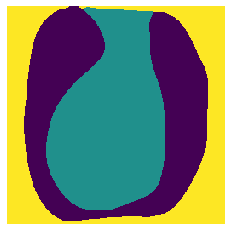

In [30]:
import imageio

def mkdir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

mkdir("sample_tests/test_f_cropped")
img_list = []
for idx, (x_batch_test, y_batch_test, orig_fp) in enumerate(test_loader):
    sample_test = model(x_batch_test[0].to(device).unsqueeze(0)).cpu().detach()
    sample_test_show = sample_test.argmax(1).squeeze()
    # print(x_batch_test)
    # print(_)
    img_list.append((sample_test_show.to(torch.uint8) + 1) * 50)
    mask_numpy = np.ones_like(sample_test_show.numpy()) * 2 - sample_test_show.numpy()
    mask_numpy = mask_numpy.astype(np.uint8)
    # print(orig_fp)
    orig_img = cv2.imread(*orig_fp) // 5 * 4
    orig_img = orig_img.astype(np.uint8)
    orig_img[..., 0] += mask_numpy * 30
    cv2.imwrite(f"./sample_tests/{orig_fp[0]}", orig_img)
    # print(f"./sample_tests/{orig_fp[0]}")
    # cv2.imwrite()

imageio.mimsave("test.gif", img_list, 'GIF', duration=0.2)

sample_test = model(x_batch_test[0].to(device).unsqueeze(0)).cpu().detach()
plt.imshow(sample_test_show)
plt.axis("off")
plt.show()

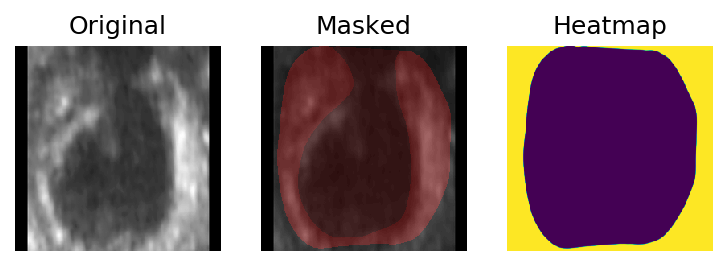

In [31]:
plt.figure(dpi=150)
plt.subplot(1, 3, 1)
plt.title('Original')
plt.imshow(x_batch_test.squeeze()[2, ...], cmap='gray')
plt.axis("off")
plt.subplot(1, 3, 2)
plt.title('Masked')
plt.imshow(orig_img)
plt.axis('off')
plt.subplot(1, 3, 3)
plt.title('Heatmap')
# print(sample_test.squeeze()[2].detach().cpu().numpy().shape)
plt.imshow(sample_test.squeeze()[2].detach().cpu())
plt.axis('off')

plt.show()
# test_dice = 0.5173, val_dice=0.9162

In [16]:
writer.add_image("Example Test, Mean: (0.2449, 0.8779, 0.9168)", 255 - 50 * (sample_test_show.unsqueeze(0) + 1), global_step=79)

In [16]:
torch.save(model.state_dict(), f"model_iter{epoch}_noatt_acc8694+9192_320x320_seed{seed}_nearest_n{BATCH_SIZE}_final_drop.pth")

In [ ]:
print(train_set.dataset.augmentation)

In [26]:
torchinfo.summary(model, input_size=(16, 3, 256, 256), depth=5)

Layer (type:depth-idx)                        Output Shape              Param #
Unet                                          --                        --
├─UnetDecoder: 1                              --                        --
│    └─ModuleList: 2-1                        --                        --
├─SegResNet: 1-1                              [16, 64, 128, 128]        --
│    └─Conv2d: 2-2                            [16, 64, 128, 128]        9,408
│    └─BatchNorm2d: 2-3                       [16, 64, 128, 128]        128
│    └─ReLU: 2-4                              [16, 64, 128, 128]        --
│    └─Attention: 2-5                         [16, 64, 128, 128]        --
│    │    └─Identity: 3-1                     [16, 64, 128, 128]        --
│    └─MaxPool2d: 2-6                         [16, 64, 64, 64]          --
│    └─Sequential: 2-7                        [16, 64, 64, 64]          --
│    │    └─BasicBlock: 3-2                   [16, 64, 64, 64]          --
│    │    │    └